# ⭐Jonas Questions
- 
- 
- 


# ⭐Imports


In [1]:
from processing_functions import *
%matplotlib inline

TensorFlow Version:  2.1.0


---

# ⭐Step 1: Preprocessing

🔴 Define helper function that
- drops the constituents column 
- converts NaN to 0
- converts values to floats

In [2]:
# preprocess(event)

# ⭐Step 2: Create Image & Average Image

### 🔵 Create Image

🔴 Define Helper Function that takes an event as input and returns an image
- Bins coordinates (η, φ, pT)
- Creates image using np.histogram2d()

In [3]:
#create_image(event, R=1.5, pixels=60)

### 🔵 Create Average Image

🔴 Define Helper Function that reads events directly from a file and returns an average image


**NOTE:** event_no list implementation for multiple images is not working properly

In [4]:
#average_image(pixels=60, R=1.5, event_no=12178, display=False):

Example (Image Progression)

In [5]:
#average_image(pixels = 100, event_no=[25, 300, 3000, 12000], display=True)

# ⭐Step 3: Extract Maxima

🔴 Define 3 Helper Functions that 

Return one vector each with the highest pT and its η, φ. (For the three maximum pT's)

- **1st function**: 1st maximum pT and its η, φ
- **2nd function**: 2nd maximum pT and its η, φ
- **3rd function**: 3rd maximum pT and its η, φ

In [6]:
#find_max1(event)
#find_max2(event)
#find_max3(event)

---

# ⭐Step 4: Centre Image

For each row, we centre a new coordinate system so that the highest pT constituent's coordinates are (φ', η') = (0, 0). <br />
This corresponds to rotating and boosting along the beam direction to center the jet.

**φ Tranformation**<br />
For the φ transformation, we subtract the φ (of the max pT) from all φ's in that row. <br />
If the values exceed [-π, π], we add 2π to the final result (if it's <-π) or subtract 2π from the final result (if it's >π). This makes sure that no values exceed the original φ interval. <br />
This has the effect of making the φ (corresponding to the max pT for that row) equal to 0 in each row, and shifting the other φ's by that same angle, while maintaining a range of 2π. <br />

**η Transformation**<br />
How does η transform? We need a Lorentz Transformation. 

**Paper** (E) <br />
Histograms binned in
either the angular separation of events or the rapidity separation of events can
be contributed to by events whose centre of mass frames are boosted by arbitrary velocities with respect to the rest frame of the detector, the lab frame.
The resulting histograms are undistorted by these centre of mass frame boosts
parallel to the beam axis, as the dependent variable is invariant with respect
to this sub–class of Lorentz boosts.

**Paper** (F): make code cell below markdown to display


In [7]:
#<img src="h1.png" width="500"> <img src="h2.png" width="500">

🔴 Define Helper Function <br />
Centers image around (φ', η') = (0, 0). Both transformations are linear (so far). 


In [8]:
#center(event, max123, output='event', R=1.5, pixels=60):

# ⭐Step 5: Rotate Image

Rotate all constituents around (φ’,η’)=0 such that the constituent with the 2nd highest pT is at 12 o’clock, i.e. at  (φ’,η’)=(0,e) with e > 0.

**Paper (C)** <br />
"Rotation: Rotation is performed to remove the stochastic nature of the decay
angle relative to the η − φ coordinate system."

🔴 Define Helper Function that

- 
- 
- 

In [9]:
#rotate(event, max2)

# ⭐Step 6: Flip Image

Flip all the constituents such that the constituents with the 3rd highest pT is on the right-half plane, i.e. at (φ’,η’)=(f,e) with f > 0

🔴 Define Helper Function that

- 
- 
- 

In [10]:
#flip(event, max3)

---

# ⭐ Building Classifier

### 🔴 Import Data

1. Import signal/background data (~7min)
2. Concatenate & Shuffle signal/background data
3. Convert to tf.data.Dataset object


**Save Dataset** **NOTE: PICKLE IMPLEMENTATION DOES NOT WORK YET**

The easiest way is to pickle it using to_pickle:

`df.to_pickle(file_name)`, where to save it, usually as a .pkl

Then you can load it back using:

`df = pd.read_pickle(file_name)`


### 🔴 Load s&b data (~7mins)

In [11]:
# # Load Previously saved data
# sdata = pd.read_pickle('sdata')
# bdata = pd.read_pickle('bdata')

# Import, Preprocess, Create Dataset
sdata = create_dataset('data_signal.dat')
bdata = create_dataset('data_background.dat')

# Save Datasets
pd.DataFrame(sdata).to_pickle('sdata')
pd.DataFrame(sdata).to_pickle('bdata')

### 🔴 Combine and Shuffle s&b data

In [12]:
# Concat and Suffle
data = np.concatenate((sdata, bdata), axis=0)
data = sklearn.utils.shuffle(data)

num_of_examples = data.shape[0]
print('Total Events:', num_of_examples)

Total Events: 29449


### 🔴 (PROBLEM HERE) Convert to tf.data.Dataset Object 

In [13]:
# Separate Examples and Labels
data= pd.DataFrame(data, columns=['examples', 'labels'])
examples= data['examples']         
labels = data['labels']            

In [14]:
examples

0        [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
1        [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
2        [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
3        [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
4        [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
                               ...                        
29444    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
29445    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
29446    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
29447    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
29448    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Name: examples, Length: 29449, dtype: object

In [15]:
labels

0        0
1        0
2        1
3        1
4        0
        ..
29444    0
29445    0
29446    0
29447    0
29448    1
Name: labels, Length: 29449, dtype: object

In [16]:
# Turn into ndarray to convert to tf.data.Dataset object
examples = np.array(examples)    # ndarray of images
labels = np.array(labels)        # ndarray of labels

In [17]:
# Convert to tf.data.Dataset object
data = tf.data.Dataset.from_tensor_slices(([examples], [labels]))

In [18]:
examples.shape

(29449,)

In [19]:
labels.shape

(29449,)

In [20]:
display(examples)
print('----------------------------------------------------------------------------------------------------------------------------------------------------------')
display(labels)

array([array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]),
       array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]),
       array([[0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       ...,
       [0.00000000e+000, 0.00000000e+000, 8.36934867e-127, ...,
        0.00000000e+000, 0.00000000e+000, 0.000

----------------------------------------------------------------------------------------------------------------------------------------------------------


array([0, 0, 1, ..., 0, 0, 1], dtype=object)

In [21]:
#list(data.as_numpy_iterator())

#### 🔴 (PROBLEM HERE: shapes are the same for all splits) Create training, validation, and test sets

In [22]:
train_size = int(0.7 * num_of_examples)
val_size = int(0.15 * num_of_examples)
test_size = int(0.15 * num_of_examples)

print(train_size, val_size, test_size)

train_data = data.take(train_size)
test_data = data.skip(train_size)
val_data = test_data.skip(val_size)
test_data = test_data.take(test_size)

print(train_data)
print(val_data)
print(test_data)

20614 4417 4417
<TakeDataset shapes: ((29449, 40, 40), (29449,)), types: (tf.float64, tf.int32)>
<SkipDataset shapes: ((29449, 40, 40), (29449,)), types: (tf.float64, tf.int32)>
<TakeDataset shapes: ((29449, 40, 40), (29449,)), types: (tf.float64, tf.int32)>


In [23]:
# from sklearn.utils import shuffle

# # Convert .dat files into DataFrame objects
# sdata = pd.DataFrame([i.strip().split() for i in open("tth_semihad.dat").readlines()])
# bdata = pd.DataFrame([i.strip().split() for i in open("wjets.dat").readlines()])

# # Label data
# sdata['label'] = np.ones(sdata.shape[0])
# bdata['label'] = np.zeros(bdata.shape[0])

# # Concatenate & Shuffle
# data = pd.concat([sdata, bdata])
# data = shuffle(data)

# # Extract labels & drop
# labels = np.array(data['label'])
# data = data.drop('label', axis=1)

#### 🔴 Visualise Data  
(TRY REMOVING NORMALISATION FROM PREPROCESSING (create_dataset), THEN DISPLAY IMAGE, THEN WHEN CREATING BATCHES USE .MAP(NORMALISE) TO NORMALISE IMAGES)

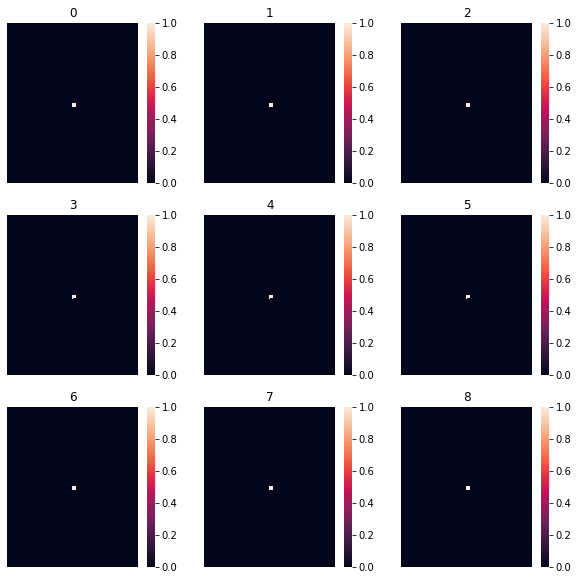

In [24]:
plt.figure(figsize=(10, 10))

for images, labels in train_data.take(1):
      for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        sns.heatmap(images[i].numpy().astype("uint8"))
        #plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(i)
        plt.axis("off")

#### 🔴 Create Batches

- `Dataset.prefetch()` overlaps data preprocessing and model execution while training.

- `Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

Theory guide: https://www.tensorflow.org/guide/data_performance#prefetching

In [25]:
-

SyntaxError: invalid syntax (<ipython-input-25-60215a10e730>, line 1)

In [ ]:
def normalise(image, label):
    image = tf.cast(image, tf.int64)                 # Set dtype to int64
    label = tf.cast(label, tf.int64)
    #image /= np.amax(image.numpy())                    # Normalise Image
    #image = tf.image.resize(image, (pixels, pixels))   # Resize image to 40x40
    return image, label

batch_size = 64

train_batches = train_data.cache().shuffle(num_of_examples//4).map(normalise).batch(batch_size, drop_remainder=True).prefetch(1)

val_batches = val_data.cache().map(normalise).batch(batch_size, drop_remainder=True).prefetch(1)  # or prefetch(buffer_size=tf.data.experimental.AUTOTUNE) 

test_batches = test_data.cache().map(normalise).batch(batch_size, drop_remainder=True).prefetch(1)

list(data.as_numpy_iterator())
train_batches

#### Batching Testing (IGNORE)

In [ ]:
for image_batch, labels_batch in train_batches:
    print(image_batch.shape)
    print(labels_batch.shape)
    #break

In [ ]:
dataset = tf.data.Dataset.range(10)

dataset = dataset.batch(3, drop_remainder=True).prefetch(1)

print(list(dataset.as_numpy_iterator()))
dataset

In [ ]:
train_batches = train_data.batch(3, drop_remainder=True).prefetch(1)

print(list(train_batches.as_numpy_iterator()))
train_batches

### 🔴 Build the Model

Look up ConvNet TF Tutorial and make a Conv2D model

In [ ]:
batch_size = 64
pixels = 40

input_shape=(batch_size, pixels, pixels)

model = tf.keras.Sequential([
          tf.keras.Input(shape=input_shape),
          tf.keras.layers.Conv2D(16, kernel_size=2, padding='same', activation='relu'),
          tf.keras.layers.MaxPooling2D(),
          tf.keras.layers.Conv2D(32, kernel_size=2, padding='same', activation='relu'),
          tf.keras.layers.MaxPooling2D(),
          tf.keras.layers.Conv2D(64, kernel_size=2, padding='same', activation='relu'),
          tf.keras.layers.MaxPooling2D(),
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(128, activation='relu'),
          tf.keras.layers.Dense(2, activation = 'softmax')
])

model.summary()

### 🔴 Compile the Model
- **Optimizer** -- Determines how the model is updated based on the data it sees and its loss function
- **Loss Function** -- Measures how accurate the model is during training
- **Metrics** -- Monitors the training and testing steps. 

### 🔴 Fit the Model

**Early Stopping**: <br /> 
Stop training when there is no improvement in the validation loss for 5 consecutive epochs or when metric gain is less than 0.001

**Save Best**: <br />
Saves the best model

In [ ]:
# Compile Model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, min_delta = 0.001)
save_best = tf.keras.callbacks.ModelCheckpoint('./best_model.h5', monitor='loss', save_best_only=True)

# Fit model to training data
EPOCHS = 10

history = model.fit(train_batches, 
          epochs=EPOCHS,
          callbacks= [early_stopping, save_best],
          validation_data=val_batches, 
          verbose=2, 
          steps_per_epoch=10
          )

In [ ]:
# Fit model to training data
EPOCHS = 10

history = model.fit(train_data, 
          epochs=EPOCHS,
          callbacks= [early_stopping, save_best],
          validation_data=val_data, 
          verbose=2, 
          steps_per_epoch=10
          )

#### Create Model-Complexity Graph 

In [ ]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs_range=range(len(training_accuracy))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs_range = range(EPOCHS)

# plt.figure(figsize=(8, 8))
# plt.subplot(1, 2, 1)
# plt.plot(epochs_range, acc, label='Training Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.show()

#### Evaluate Model

In [ ]:
# loss, accuracy = my_model.evaluate(test_data, verbose=2)

# print('\nLoss on the TEST Set: {:,.3f}'.format(loss))
# print('Accuracy on the TEST Set: {:.3%}'.format(accuracy))

### 🔴 Make Predictions

In [ ]:
# for event, label in test_data.take(1):
#     ps = model.predict(event)
#     images = event.numpy().squeeze()
#     labels = label.numpy()


# plt.figure(figsize=(10,15))

# for n in range(30):
#     plt.subplot(6,5,n+1)
#     plt.imshow(images[n], cmap = plt.cm.binary)
#     color = 'green' if np.argmax(ps[n]) == labels[n] else 'red'
#     plt.title(class_names[np.argmax(ps[n])], color=color)
#     plt.axis('off')

In [ ]:
# for event, label in training_batches.take(1):
#     ps = model.predict(event)
#     first_image = event.numpy().squeeze()[0]
  
  
# fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
# ax1.imshow(first_image, cmap = plt.cm.binary)
# ax1.axis('off')
# ax2.barh(np.arange(10), ps[0])
# ax2.set_aspect(0.1)
# ax2.set_yticks(np.arange(10))
# ax2.set_yticklabels(np.arange(10))
# ax2.set_title('Class Probability')
# ax2.set_xlim(0, 1.1)
# plt.tight_layout()

### 🔴 Build Confusion Matrix 

Guide:
https://kapernikov.com/tutorial-image-classification-with-scikit-learn/